# VAR Model with Air Quality and Weather Data

This notebook builds a VAR model using both air quality measurements and weather data as endogenous variables.

In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Load and Concatenate Air Quality + Weather Data

In [33]:
# Load air quality data
aqi_df = pd.read_csv('data/processed/cleaned/cleaned_air.csv', index_col=0, parse_dates=True)
aqi_df.index.freq = "h"

# Load weather data
weather_df = pd.read_csv('data/processed/cleaned/cleaned_weather.csv', index_col=0, parse_dates=True)
weather_df.index.freq = "h"

print(f"Air quality data shape: {aqi_df.shape}")
print(f"Weather data shape: {weather_df.shape}")

Air quality data shape: (29497, 6)
Weather data shape: (29497, 8)


In [34]:
# Concatenate air quality and weather data
combined_df = pd.concat([aqi_df, weather_df], axis=1)
combined_df.index.freq = "h"

print(f"Combined data shape: {combined_df.shape}")
print("\nColumns:")
print(combined_df.columns.tolist())
combined_df.head()

Combined data shape: (29497, 14)

Columns:
['carbon_monoxide', 'pm10', 'pm2_5', 'nitrogen_dioxide', 'ozone', 'sulphur_dioxide', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m']


,carbon_monoxide,pm10,pm2_5,nitrogen_dioxide,ozone,sulphur_dioxide,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m
2022-08-04 00:00:00,595.0,58.0,40.3,29.7,24.0,16.8,28.3,87,25.9,0.0,1003.2,20,4.9,144
2022-08-04 01:00:00,552.0,43.5,30.0,25.0,49.0,18.2,29.4,82,26.1,0.0,1003.4,100,4.0,170
2022-08-04 02:00:00,492.0,47.3,32.7,18.4,84.0,20.2,30.3,80,26.4,0.0,1003.1,100,0.8,243
2022-08-04 03:00:00,429.0,50.3,34.9,11.2,128.0,22.0,31.5,76,26.9,0.0,1002.9,93,3.3,319
2022-08-04 04:00:00,414.0,55.2,38.3,8.6,154.0,21.5,32.4,73,27.0,0.0,1002.6,97,3.8,343


## Parameters

VAR lag order (obtained from data exploration)

In [35]:
p = 2  # VAR lag order

## Model Cross-Validation

In [36]:
splits = 5
val_len = 24
all_cols = combined_df.columns
aqi_cols = aqi_df.columns  # We primarily care about forecasting these
tscv = TimeSeriesSplit(n_splits=splits, test_size=val_len)

In [37]:
mape_list = {comp: [] for comp in aqi_cols}
mase_list = {comp: [] for comp in aqi_cols}

for train_index, val_index in tscv.split(combined_df):
    train, val = combined_df.iloc[train_index], combined_df.iloc[val_index]
    model = VAR(train)
    fit = model.fit(maxlags=p)
    
    # Forecast using the last p observations from training data
    forecast = fit.forecast(train.values[-p:], steps=len(val))
    forecast_df = pd.DataFrame(forecast, index=val.index, columns=all_cols)
    
    # Calculate metrics only for air quality columns
    for comp in aqi_cols:
        mape = mean_absolute_percentage_error(val[comp], forecast_df[comp])
        if mape > 5:
            continue
        mae = mean_absolute_error(val[comp], forecast_df[comp])
        # Naive prediction: use value at t to guess value at t + len(val) 
        naive_mae = np.mean(np.abs(train[comp][-len(val):].values - val[comp].values))
        mase = mae / naive_mae
        mape_list[comp].append(mape)
        mase_list[comp].append(mase)

# Calculate mean scores
mape_means = {comp: np.mean(scores) for comp, scores in mape_list.items()}
mase_means = {comp: np.mean(scores) for comp, scores in mase_list.items()}

In [38]:
results = pd.DataFrame({'mape': mape_means, 'mase': mase_means}).T
print("Cross-validation results for Air Quality components:")
results

Cross-validation results for Air Quality components:


,carbon_monoxide,pm10,pm2_5,nitrogen_dioxide,ozone,sulphur_dioxide
mape,0.302632,0.647399,0.648626,0.690884,0.426257,0.342388
mase,1.083119,0.743794,0.761835,0.876131,1.126406,0.833647


## Compare with Air-Only VAR

Let's compare the metrics with the air-only VAR model to see if adding weather data improves the forecast.

In [39]:
# Air-only VAR for comparison
mape_list_air = {comp: [] for comp in aqi_cols}
mase_list_air = {comp: [] for comp in aqi_cols}

for train_index, val_index in tscv.split(aqi_df):
    train, val = aqi_df.iloc[train_index], aqi_df.iloc[val_index]
    model = VAR(train)
    fit = model.fit(maxlags=2)  # Using original p=2 for fair comparison
    
    forecast = fit.forecast(train.values[-2:], steps=len(val))
    forecast_df = pd.DataFrame(forecast, index=val.index, columns=aqi_cols)
    
    for comp in aqi_cols:
        mape = mean_absolute_percentage_error(val[comp], forecast_df[comp])
        if mape > 5:
            continue
        mae = mean_absolute_error(val[comp], forecast_df[comp])
        naive_mae = np.mean(np.abs(train[comp][-len(val):].values - val[comp].values))
        mase = mae / naive_mae
        mape_list_air[comp].append(mape)
        mase_list_air[comp].append(mase)

mape_means_air = {comp: np.mean(scores) for comp, scores in mape_list_air.items()}
mase_means_air = {comp: np.mean(scores) for comp, scores in mase_list_air.items()}

In [40]:
# Comparison table
comparison = pd.DataFrame({
    'MAPE (Air+Weather)': mape_means,
    'MAPE (Air Only)': mape_means_air,
    'MASE (Air+Weather)': mase_means,
    'MASE (Air Only)': mase_means_air
})

# Calculate improvement
comparison['MAPE Improvement'] = (comparison['MAPE (Air Only)'] - comparison['MAPE (Air+Weather)']) / comparison['MAPE (Air Only)'] * 100
comparison['MASE Improvement'] = (comparison['MASE (Air Only)'] - comparison['MASE (Air+Weather)']) / comparison['MASE (Air Only)'] * 100

print("Comparison of Air+Weather VAR vs Air-Only VAR:")
print("(Positive improvement % means Air+Weather is better)\n")
comparison

Comparison of Air+Weather VAR vs Air-Only VAR:
(Positive improvement % means Air+Weather is better)



,MAPE (Air+Weather),MAPE (Air Only),MASE (Air+Weather),MASE (Air Only),MAPE Improvement,MASE Improvement
carbon_monoxide,0.302632,0.350467,1.083119,1.255928,13.648925,13.759465
pm10,0.647399,0.714596,0.743794,0.798024,9.403566,6.795464
pm2_5,0.648626,0.702724,0.761835,0.812399,7.698264,6.224031
nitrogen_dioxide,0.690884,0.712783,0.876131,0.916576,3.072253,4.412594
ozone,0.426257,0.560778,1.126406,1.334498,23.988211,15.593262
sulphur_dioxide,0.342388,0.359016,0.833647,0.880790,4.631625,5.352272


## Fit Model on Full Training Data

In [41]:
model = VAR(combined_df)
fit = model.fit(maxlags=p)
print(fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Dec, 2025
Time:                     07:53:52
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                    30.7946
Nobs:                     29495.0    HQIC:                   30.7171
Log likelihood:      -1.03798e+06    FPE:                2.11042e+13
AIC:                      30.6805    Det(Omega_mle):     2.08158e+13
--------------------------------------------------------------------
Results for equation carbon_monoxide
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                         -63.498720       172.483080           -0.368           0.713
L1.carbon_monoxide              1.655254         0.004942          334.968           0.000
L1.pm10   

In [42]:
# Save the model
import os
os.makedirs("models/var_air_weather", exist_ok=True)
fit.save("models/var_air_weather/var_air_weather_model.pickle")
print("Model saved to models/var_air_weather/var_air_weather_model.pickle")

Model saved to models/var_air_weather/var_air_weather_model.pickle


## Forecast Example

In [43]:
# Generate 24-hour forecast
forecast_steps = 24
forecast = fit.forecast(combined_df.values[-p:], steps=forecast_steps)
forecast_df = pd.DataFrame(
    forecast, 
    index=pd.date_range(start=combined_df.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='h'),
    columns=all_cols
)

print("24-hour Forecast for Air Quality components:")
forecast_df[aqi_cols]

24-hour Forecast for Air Quality components:


,carbon_monoxide,pm10,pm2_5,nitrogen_dioxide,ozone,sulphur_dioxide
2025-12-15 01:00:00,1959.124796,72.787666,71.464918,37.178168,21.333704,38.636314
2025-12-15 02:00:00,1790.668227,66.316852,65.606267,31.698026,37.144701,36.853962
2025-12-15 03:00:00,1542.903486,60.097403,60.182370,25.970259,54.799824,34.924810
2025-12-15 04:00:00,1264.634899,54.266475,55.145001,20.746142,72.068042,32.880038
2025-12-15 05:00:00,999.606457,49.291348,50.800169,16.696702,86.941529,30.870166
2025-12-15 06:00:00,780.678940,45.639054,47.502792,14.268321,97.972036,29.088753
2025-12-15 07:00:00,627.440468,43.610248,45.498446,13.632716,104.396385,27.709412
2025-12-15 08:00:00,546.382775,43.277062,44.858483,14.697992,106.124995,26.844850
2025-12-15 09:00:00,532.898514,44.489168,45.476328,17.160349,103.637032,26.528752
2025-12-15 10:00:00,574.359353,46.921986,47.101794,20.578575,97.819322,26.717197


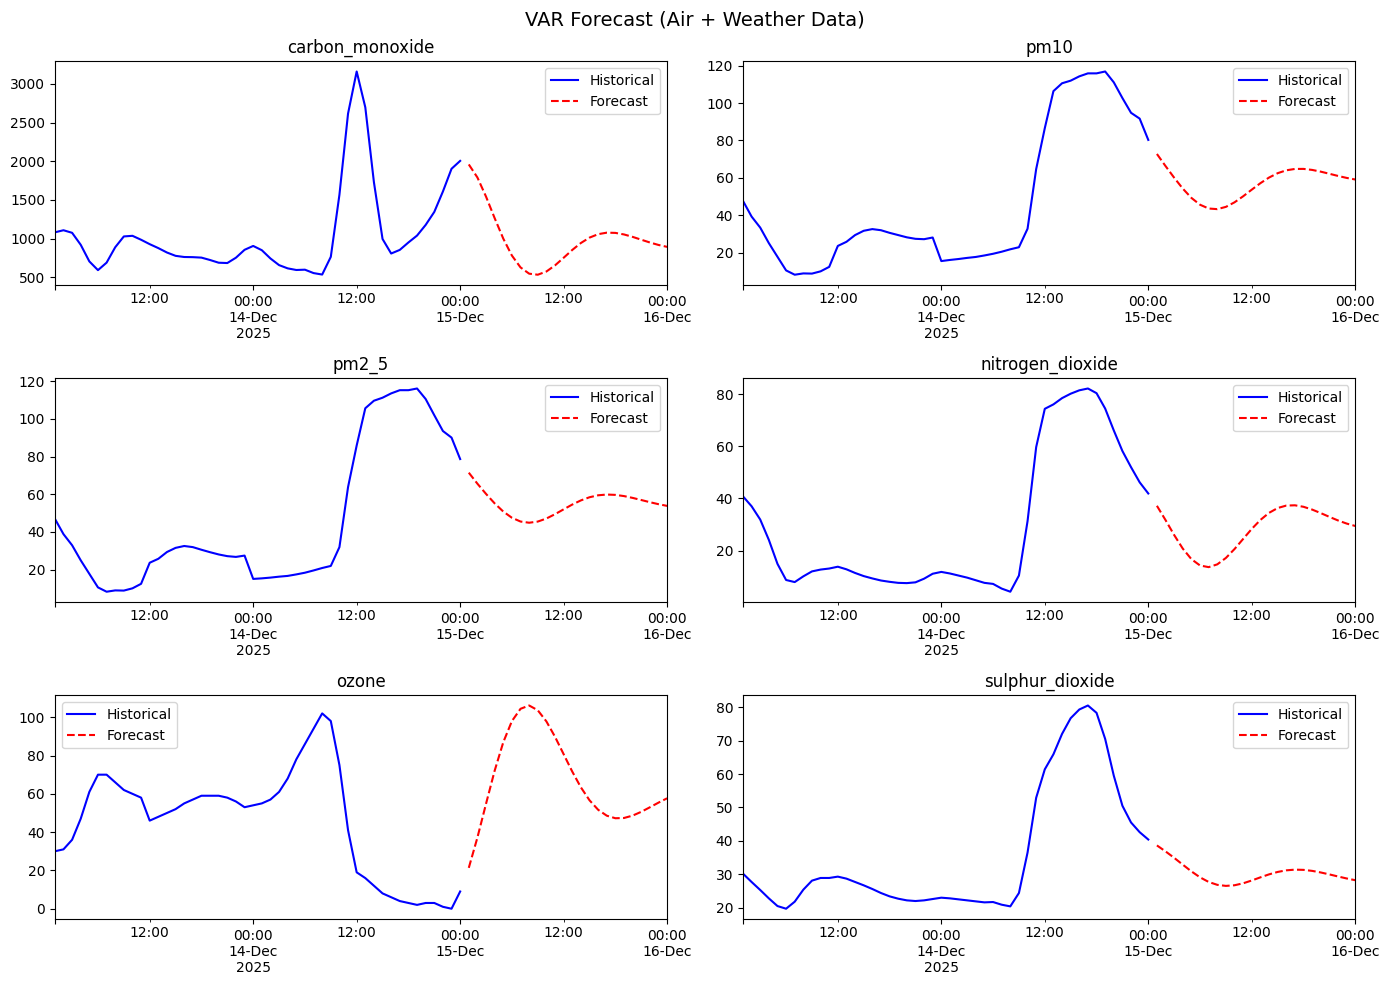

In [44]:
# Visualize forecast
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i, comp in enumerate(aqi_cols):
    ax = axes[i]
    # Plot last 48 hours of historical data
    combined_df[comp].iloc[-48:].plot(ax=ax, label='Historical', color='blue')
    # Plot forecast
    forecast_df[comp].plot(ax=ax, label='Forecast', color='red', linestyle='--')
    ax.set_title(comp)
    ax.legend()
    ax.set_xlabel('')

plt.suptitle('VAR Forecast (Air + Weather Data)', fontsize=14)
plt.tight_layout()
plt.show()